In [1]:
import cv2
import os
import torch
import numpy as np
from torchvision import transforms
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from PIL import Image
import torchvision
import matplotlib.pyplot as plt
from tensorboardX import SummaryWriter

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 导入数据

## 数据集结构
```
data/ 
    benign/ 
        benign (1).png 
        benign (1)_mask.png 
        ... 
    malignant/ 
        malignant (1).png 
        malignant (1)_mask.png 
        ... 
    normal/ 
        normal (1).png 
        normal (1)_mask.png 
        ... 
```
其中，mask为肿瘤的位置，部分数据还有mask_1和mask_2，分别标示第二和第三个肿瘤的位置。

为了更好实现分割任务并更加充分的使用数据，将多个mask（如果有）做加和，就得到了一张片子的肿瘤信息。


In [3]:
import os
from PIL import Image, ImageChops
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class BreastUltrasoundDataset(Dataset):
    def __init__(self, data_dir, transform=None, mask_transform=None, task="classification"):
        self.data_dir = data_dir
        self.transform = transform
        self.mask_transform = mask_transform
        self.task = task
        self.classes = ["benign", "malignant", "normal"]  
        self.num_classes = len(self.classes) 
        self.images = [] 
        self.masks = []  
        self.one_hot_labels = []  

        for label, class_name in enumerate(self.classes):
            class_dir = os.path.join(data_dir, class_name)
            for filename in os.listdir(class_dir):
                if filename.endswith(".png") and "_mask" not in filename:  
                    img_path = os.path.join(class_dir, filename)
                    image = Image.open(img_path).convert("RGB")  # 主要是Resnet-50输入是RGB的,实际上应该用灰度，懒得改了
                    self.images.append(image)
                    one_hot = torch.zeros(self.num_classes)
                    one_hot[label] = 1
                    self.one_hot_labels.append(one_hot)

                    if self.task == "segmentation":
                        base_path = img_path[:-4]  # 去掉 ".png"
                        mask_path = base_path + "_mask.png"

                        if os.path.exists(mask_path):
                            mask = Image.open(mask_path).convert("L")  
                        
                        mask_path_1 = base_path + "_mask_1.png"
                        if os.path.exists(mask_path_1):
                            mask2 = Image.open(mask_path_1).convert("L")
                            mask = ImageChops.add(mask, mask2)
                        mask_path_2 = base_path + "_mask_2.png"
                        if os.path.exists(mask_path_2):
                            mask3 = Image.open(mask_path_2).convert("L")
                            mask = ImageChops.add(mask, mask3)
                        self.masks.append(mask)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]

        if self.task == "segmentation":
            mask = self.masks[idx]
        else:
            mask = None

        if self.transform:
            image = self.transform(image)
        if mask is not None and self.mask_transform:
            mask = self.mask_transform(mask)

        if self.task == "classification":
            one_hot_label = self.one_hot_labels[idx]
            return image, one_hot_label
        elif self.task == "segmentation":
            return image, mask
image_transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


mask_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor() 
])

# 这里实际上没有做数据增强，只是将图像和 mask 转换为张量

# 创建数据集实例
data_dir = "./data"
classification_dataset = BreastUltrasoundDataset(data_dir, transform=image_transform, task="classification")
segmentation_dataset = BreastUltrasoundDataset(data_dir, transform=mask_transform, mask_transform=mask_transform, task="segmentation")

# 创建 DataLoader
classification_loader = DataLoader(classification_dataset, batch_size=16, shuffle=True)
segmentation_loader = DataLoader(segmentation_dataset, batch_size=16, shuffle=True)

# 测试数据集
for images, labels in classification_loader:
    print("Classification batch - Images shape:", images.shape, "Labels shape:", labels.shape)
    break

for images, masks in segmentation_loader:
    print("Segmentation batch - Images shape:", images.shape, "Masks shape:", masks.shape)
    break

Classification batch - Images shape: torch.Size([16, 3, 224, 224]) Labels shape: torch.Size([16, 3])
Segmentation batch - Images shape: torch.Size([16, 3, 224, 224]) Masks shape: torch.Size([16, 1, 224, 224])


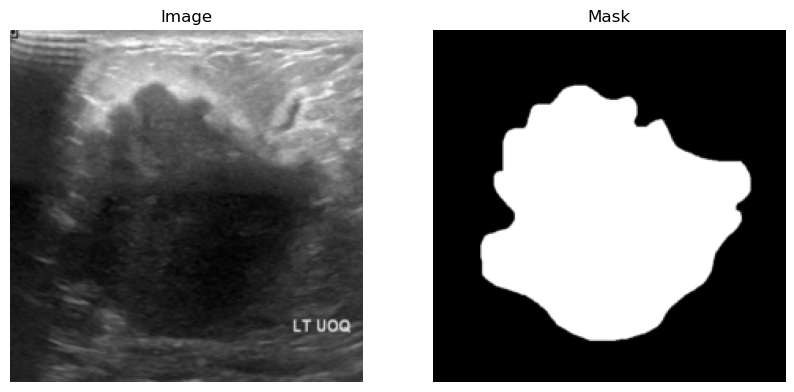

In [96]:
import matplotlib.pyplot as plt

for images, masks in segmentation_loader:
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(images[0].permute(1, 2, 0))  # 将张量转换为 HWC 格式
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(masks[0].squeeze(), cmap="gray")  # 显示灰度 mask
    plt.title("Mask")
    plt.axis("off")

    plt.show()
    break

# HW3

In [ ]:
dataset = classification_dataset

780


: 

In [ ]:
train_dataset,test_dataset = torch.utils.data.random_split(dataset,[len(dataset)-len(dataset)//5,len(dataset)//5])
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=32,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=32,shuffle=False)

In [99]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## ResNet-50模型简介
ResNet-50 是一种深度卷积神经网络，最初由 Kaiming He 等人在 2015 年提出。它是 ResNet 系列的一部分，因其在 ImageNet 图像分类任务中的出色表现而广受欢迎。ResNet-50 通过引入残差块（Residual Block）解决了深层网络中的梯度消失问题，使得网络可以更深、更有效地进行训练。

ResNet-50 由 50 层深度卷积层组成，主要包括以下几个部分：

1. **卷积层和池化层**：最初的几层用于提取低级特征，如边缘和纹理。
2. **残差块**：核心部分由多个残差块组成，每个残差块包含多个卷积层和一个快捷连接（skip connection），用于直接将输入传递到输出，缓解梯度消失问题。
3. **全局平均池化层**：在网络的末端，使用全局平均池化层将特征图转换为固定大小的向量。
4. **全连接层**：最后，通过一个全连接层将特征向量映射到分类标签。

在本项目中，我们使用预训练的 ResNet-50 模型，并将其最后一层修改为适应我们的分类任务。通过迁移学习，我们可以利用预训练模型的特征提取能力，提高分类性能。

In [100]:
class Resnet(nn.Module):
    def __init__(self):
        super(Resnet, self).__init__()
        self.resnet = torchvision.models.resnet50(pretrained=True)
        self.resnet.fc = nn.Linear(2048, 3)

    def forward(self, x):
        return self.resnet(x)

In [101]:
def train(model, args, train_loader, test_loader):
    '''
    Model training function
    input: 
        model: linear classifier or full-connected neural network classifier
        args: configuration
    '''
    # create optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)
    # create scheduler 
    import math

    warm_up_iter = 5
    T_max = 20
    lr_max = 0.01
    lr_min = 1e-5

    def WarmupCosineAnnealingLR(cur_iter):
        if cur_iter < warm_up_iter:
            return (lr_max - lr_min) * (cur_iter / warm_up_iter) + lr_min
        else:
            return lr_min + 0.5 * (lr_max - lr_min) * (
                1 + math.cos((cur_iter - warm_up_iter) / (T_max - warm_up_iter) * math.pi)
            )

    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, WarmupCosineAnnealingLR)

    # create summary writer
    writer = SummaryWriter()
    training_loss = []
    training_accuracy = []
    testing_loss = []
    testing_accuracy = []
        # train
    for epoch in range(20):
        model.train()
        curr_loss = 0
        correct = 0
        total = 0
        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            outputs = torch.flatten(outputs,1)
            labels = torch.flatten(labels,1)
            loss = F.cross_entropy(outputs, labels)
            loss.backward()
            optimizer.step()
            curr_loss += loss.item()
            total += labels.size(0)
            correct += (outputs.argmax(1) == labels.argmax(1)).sum().item()
            if i % 10 == 0:
                print(f'Epoch {epoch + 1}/{20}, Iteration {i}/{len(train_loader)}, Loss: {loss.item()}, Accuracy: {correct / total}')
        training_loss.append(curr_loss / len(train_loader))
        training_accuracy.append(correct / total)
        with torch.no_grad():
            curr_loss = 0
            correct = 0
            total = 0
            model.eval()
            for i, (inputs, labels) in enumerate(test_loader):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = F.cross_entropy(outputs, labels)
                curr_loss += loss.item()
                total += labels.size(0)
                correct += (outputs.argmax(1) == labels.argmax(1)).sum().item()
            testing_loss.append(curr_loss / len(test_loader))
            testing_accuracy.append(correct / total)
        writer.add_scalars(f'{args}_Loss', {'train': training_loss[-1], 'test': testing_loss[-1]}, epoch + 1)
        writer.add_scalars(f'{args}_Accuracy', {'train': training_accuracy[-1], 'test': testing_accuracy[-1]}, epoch + 1)
        scheduler.step()
        print(f'Epoch {epoch + 1}/{20}, Training Loss: {training_loss[-1]}, Training Accuracy: {training_accuracy[-1]}, Testing Loss: {testing_loss[-1]}, Testing Accuracy: {testing_accuracy[-1]}')
    torch.save(model.state_dict(), f'models/{args}_checkpoint.pth')
    writer.close()
    plt.plot(training_loss, label='train')
    plt.plot(testing_loss, label='test')
    plt.plot(training_accuracy, label='train')
    plt.plot(testing_accuracy, label='test')
    plt.xlabel('Epoch')
    plt.ylabel('Loss/Accuracy')
    plt.title(f'{args} Loss/Accuracy')
    plt.legend()
    plt.savefig(f'{args}.png')
    plt.close()

In [102]:
model = Resnet().to(device)

/home/llt/.conda/envs/pytorch/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/llt/.conda/envs/pytorch/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [103]:
train(model, 'Resnet50', train_loader, test_loader)

Epoch 1/20, Iteration 0/20, Loss: 1.1816177368164062, Accuracy: 0.3125
Epoch 1/20, Iteration 10/20, Loss: 1.0829166173934937, Accuracy: 0.40625
Epoch 1/20, Training Loss: 1.0999190509319305, Training Accuracy: 0.40384615384615385, Testing Loss: 1.1078977584838867, Testing Accuracy: 0.358974358974359
Epoch 2/20, Iteration 0/20, Loss: 1.0599615573883057, Accuracy: 0.53125
Epoch 2/20, Iteration 10/20, Loss: 0.9362526535987854, Accuracy: 0.5397727272727273
Epoch 2/20, Training Loss: 0.9926527082920075, Training Accuracy: 0.5705128205128205, Testing Loss: 0.8900703191757202, Testing Accuracy: 0.5961538461538461
Epoch 3/20, Iteration 0/20, Loss: 0.8688209652900696, Accuracy: 0.53125
Epoch 3/20, Iteration 10/20, Loss: 0.7455116510391235, Accuracy: 0.6619318181818182
Epoch 3/20, Training Loss: 0.7574624836444854, Training Accuracy: 0.7035256410256411, Testing Loss: 0.5520406126976013, Testing Accuracy: 0.7756410256410257
Epoch 4/20, Iteration 0/20, Loss: 0.6714951992034912, Accuracy: 0.6875
Ep

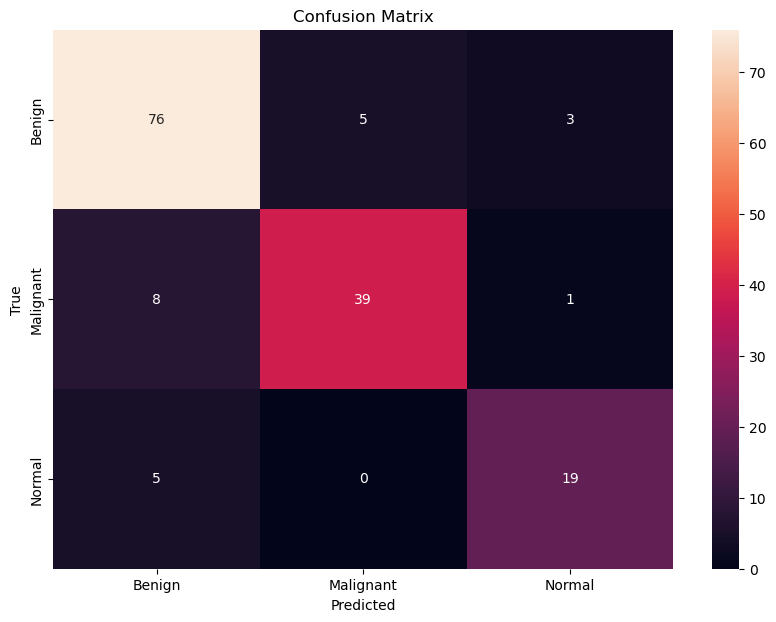

In [104]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(model, loader, classes):
    all_preds = []
    all_labels = []
    model.eval()
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.argmax(dim=1).cpu().numpy())
    
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# 使用训练好的模型和测试数据绘制混淆矩阵
plot_confusion_matrix(model, test_loader, classes=['Benign', 'Malignant', 'Normal'])

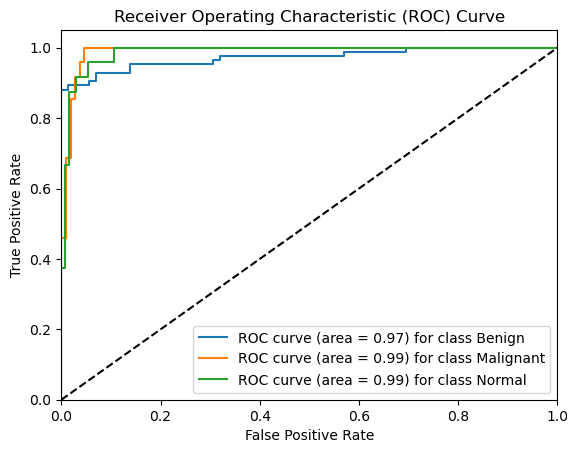

In [105]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

import matplotlib.pyplot as plt

def plot_roc_curve(model, loader, classes):
    all_labels = []
    all_probs = []
    model.eval()
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(len(classes)):
        fpr[i], tpr[i], _ = roc_curve(all_labels[:, i], all_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve
    plt.figure()
    for i in range(len(classes)):
        plt.plot(fpr[i], tpr[i], label=f'ROC curve (area = {roc_auc[i]:.2f}) for class {classes[i]}')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# 使用训练好的模型和测试数据绘制ROC曲线
plot_roc_curve(model, test_loader, classes=['Benign', 'Malignant', 'Normal'])

## baseline
这里选择KNN作为我们的baseline.

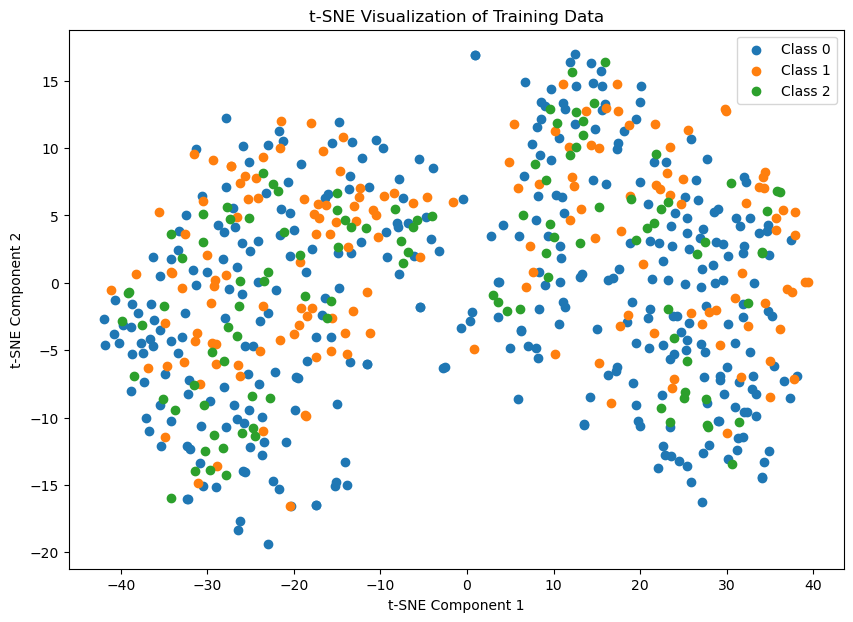

Training Accuracy: 0.7564102564102564
Testing Accuracy: 0.5192307692307693


In [113]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE

# 将数据转换为适合KNN模型的格式
def prepare_data(loader):
    data = []
    labels = []
    for inputs, targets in loader:
        inputs = inputs.view(inputs.size(0), -1)  # 展平输入
        data.append(inputs.cpu().numpy())
        labels.append(targets.argmax(dim=1).cpu().numpy())
    data = np.concatenate(data, axis=0)
    labels = np.concatenate(labels, axis=0)
    return data, labels

PCA_COMPONENTS = 30
# 准备训练和测试数据
train_data, train_labels = prepare_data(train_loader)
test_data, test_labels = prepare_data(test_loader)

# 使用PCA进行特征提取
pca = PCA(n_components=PCA_COMPONENTS)
train_data = pca.fit_transform(train_data)
test_data = pca.transform(test_data)
# 使用t-SNE进行降维
tsne = TSNE(n_components=2, random_state=42)
train_data_tsne = tsne.fit_transform(train_data)

# 可视化
plt.figure(figsize=(10, 7))
for i, label in enumerate(np.unique(train_labels)):
    plt.scatter(train_data_tsne[train_labels == label, 0], train_data_tsne[train_labels == label, 1], label=f'Class {label}')
plt.legend()
plt.title('t-SNE Visualization of Training Data')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()
# 创建KNN模型并进行训练
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(train_data, train_labels)

# 进行预测
train_preds = knn.predict(train_data)
test_preds = knn.predict(test_data)

# 计算准确率
train_accuracy = accuracy_score(train_labels, train_preds)
test_accuracy = accuracy_score(test_labels, test_preds)

print(f'Training Accuracy: {train_accuracy}')
print(f'Testing Accuracy: {test_accuracy}')

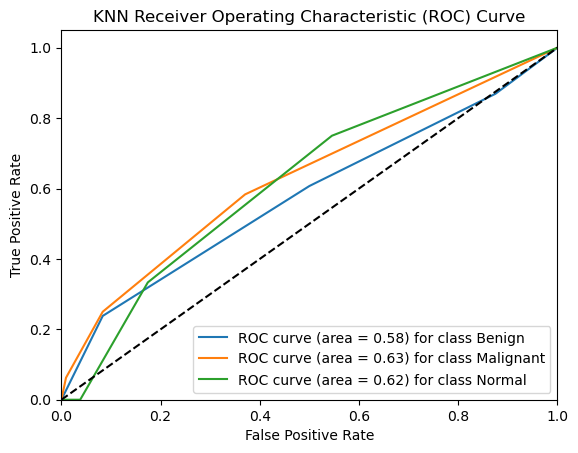

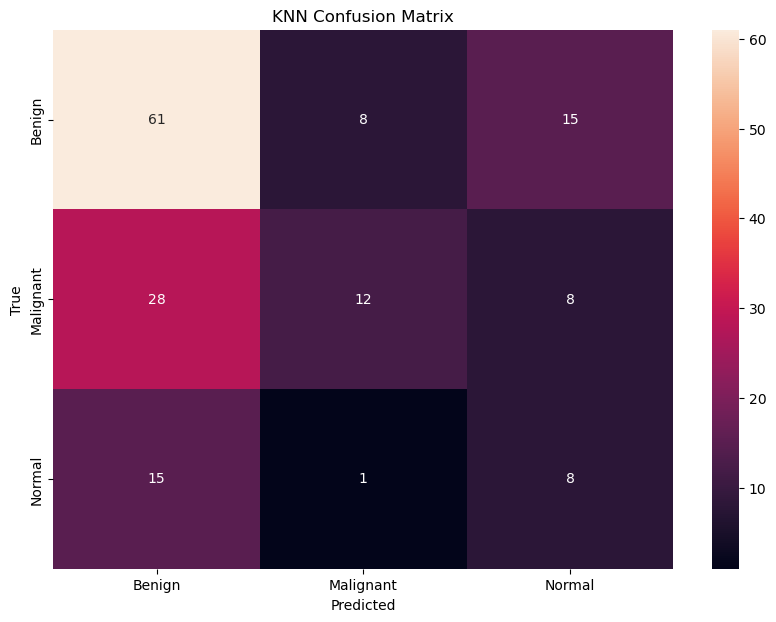

In [114]:
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix
import seaborn as sns

import matplotlib.pyplot as plt

# 计算KNN模型的预测概率
knn_probs = knn.predict_proba(test_data)

# 绘制ROC曲线
def plot_knn_roc_curve(knn_probs, test_labels, classes):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(len(classes)):
        fpr[i], tpr[i], _ = roc_curve(test_labels == i, knn_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure()
    for i in range(len(classes)):
        plt.plot(fpr[i], tpr[i], label=f'ROC curve (area = {roc_auc[i]:.2f}) for class {classes[i]}')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('KNN Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# 绘制混淆矩阵
def plot_knn_confusion_matrix(test_labels, test_preds, classes):
    cm = confusion_matrix(test_labels, test_preds)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('KNN Confusion Matrix')
    plt.show()

# 使用KNN模型和测试数据绘制ROC曲线和混淆矩阵
plot_knn_roc_curve(knn_probs, test_labels, classes=['Benign', 'Malignant', 'Normal'])
plot_knn_confusion_matrix(test_labels, test_preds, classes=['Benign', 'Malignant', 'Normal'])

## 分析
ResNet模型在分类任务中的表现远优于KNN模型。以下是支持这一结论的证据：

1. **准确率（Accuracy）**：
    - ResNet模型的训练准确率为 **98%**，测试准确率为 **91%**。
    - KNN模型的训练准确率为 **75.64%**，测试准确率为 **51.92%**。

2. **ROC曲线（ROC Curve）**：
    - ResNet模型的ROC曲线显示出更高的AUC值，表明其在区分不同类别时具有更好的性能。
    - KNN模型的ROC曲线AUC值较低，说明其分类能力较弱。

3. **混淆矩阵（Confusion Matrix）**：
    - ResNet模型的混淆矩阵显示出更高的分类准确率，尤其是在区分良性、恶性和正常类别时表现更好。
    - KNN模型的混淆矩阵显示出较多的分类错误，尤其是在区分恶性和正常类别时表现较差。

综上所述，ResNet模型在分类任务中的表现明显优于KNN模型。

# HW4

In [86]:
def train(model, args, train_loader, test_loader):
    '''
    Model training function
    input: 
        model: linear classifier or full-connected neural network classifier
        args: configuration
    '''
    # create optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)
    # create scheduler 
    import math
    
    def dice_loss(input, target, alpha=0.5):
        smooth = 1.0
        intersection = (input * target).sum(dim=(2, 3))
        union = input.sum(dim=(2, 3)) + target.sum(dim=(2, 3))
        dice = (2. * intersection + smooth) / (union + smooth)
        dice_loss = 1 - dice.mean()

        bce_loss = torch.nn.functional.binary_cross_entropy(input, target)
        return alpha * dice_loss + (1 - alpha) * bce_loss

    # create summary writer
    writer = SummaryWriter()
    training_loss = []
    testing_loss = []
    # train
    for epoch in range(20):
        model.train()
        curr_loss = 0
        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = dice_loss(outputs, labels)
            loss.backward()
            optimizer.step()
            curr_loss += loss.item()
            if i % 10 == 0:
                print(f'Epoch {epoch + 1}/{20}, Iteration {i}/{len(train_loader)}, Loss: {loss.item()}')
        training_loss.append(curr_loss / len(train_loader))
        with torch.no_grad():
            curr_loss = 0
            model.eval()
            for i, (inputs, labels) in enumerate(test_loader):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = dice_loss(outputs, labels)
                curr_loss += loss.item()
            testing_loss.append(curr_loss / len(test_loader))
        writer.add_scalars(f'{args}_Loss', {'train': training_loss[-1], 'test': testing_loss[-1]}, epoch + 1)
        print(f'Epoch {epoch + 1}/{20}, Training Loss: {training_loss[-1]},  Testing Loss: {testing_loss[-1]}')
    torch.save(model.state_dict(), f'models/{args}_checkpoint.pth')
    writer.close()
    plt.plot(training_loss, label='train')
    plt.plot(testing_loss, label='test')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{args} Loss')
    plt.legend()
    plt.savefig(f'{args}.png')
    plt.close()

# U-Net

U-Net是一种用于图像分割的卷积神经网络架构。U-Net的设计使其能够在医学图像分割任务中表现出色。其主要特点包括对称的编码器-解码器结构和跳跃连接（skip connections），使得网络能够更好地捕捉图像的细节信息。

### U-Net的主要组成部分

1. **编码器（Encoder）**：
    - 编码器部分由多个卷积层和池化层组成，用于提取图像的特征。
    - 每个卷积块包含两个3x3卷积层和一个ReLU激活函数，后接一个2x2最大池化层，用于下采样。

2. **解码器（Decoder）**：
    - 解码器部分由多个反卷积层和卷积层组成，用于逐步恢复图像的空间分辨率。
    - 每个反卷积块包含一个2x2反卷积层（上采样），后接两个3x3卷积层和一个ReLU激活函数。

3. **跳跃连接（Skip Connections）**：
    - 跳跃连接将编码器中的特征图直接传递到解码器的相应层，帮助恢复图像的细节信息。
    - 这些连接通过拼接操作将编码器和解码器的特征图连接起来。

4. **最终输出层**：
    - 最后一层是一个1x1卷积层，用于将特征图映射到所需的输出通道数（通常是分割掩码的类别数）。

In [72]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()
        self.encoder1 = self.contracting_block(in_channels, 64)
        self.encoder2 = self.contracting_block(64, 128)
        self.encoder3 = self.contracting_block(128, 256)
        self.encoder4 = self.contracting_block(256, 512)
        
        self.bottom = self.contracting_block(512, 1024)
        
        self.decoder4 = self.expansive_block(1024 + 512, 512)  # 拼接后通道数为1024+512
        self.decoder3 = self.expansive_block(512 + 256, 256)  # 拼接后通道数为512+256
        self.decoder2 = self.expansive_block(256 + 128, 128)  # 拼接后通道数为256+128        
        self.final_layer = nn.Conv2d(128, out_channels, kernel_size=1)
    
    def contracting_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
    
    def expansive_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        # Encoding path
        enc1 = self.encoder1(x)  # [B, 64, H, W]
        enc2 = self.encoder2(F.max_pool2d(enc1, kernel_size=2))  # [B, 128, H/2, W/2]
        enc3 = self.encoder3(F.max_pool2d(enc2, kernel_size=2))  # [B, 256, H/4, W/4]
        enc4 = self.encoder4(F.max_pool2d(enc3, kernel_size=2))  # [B, 512, H/8, W/8]
        
        # Bottleneck
        bottom = self.bottom(F.max_pool2d(enc4, kernel_size=2))  # [B, 1024, H/16, W/16]

        # 使用 size 来确保上采样后的大小正确
        dec4 = self.decoder4(torch.cat([F.interpolate(bottom, size=enc4.shape[2:], mode='bilinear', align_corners=True), enc4], dim=1))  # [B, 512, H/8, W/8]
        dec3 = self.decoder3(torch.cat([F.interpolate(dec4, size=enc3.shape[2:], mode='bilinear', align_corners=True), enc3], dim=1))    # [B, 256, H/4, W/4]
        dec2 = self.decoder2(torch.cat([F.interpolate(dec3, size=enc2.shape[2:], mode='bilinear', align_corners=True), enc2], dim=1))    # [B, 128, H/2, W/2]        
        return torch.sigmoid(self.final_layer(dec2))  # Final output [B, 1, H, W]


In [87]:
train_dataset,test_dataset = torch.utils.data.random_split(segmentation_dataset,[len(segmentation_dataset)-len(segmentation_dataset)//5,len(segmentation_dataset)//5])
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=8,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=8,shuffle=False)


In [88]:
model = UNet().to(device)


In [73]:
print(f"Train dataset length: {len(train_loader.dataset)}")
print(f"Test dataset length: {len(test_loader.dataset)}")

Train dataset length: 624
Test dataset length: 156


In [89]:
train(model, 'UNet', train_loader, test_loader)

Epoch 1/20, Iteration 0/78, Loss: 0.7834776639938354
Epoch 1/20, Iteration 10/78, Loss: 0.7857365608215332
Epoch 1/20, Iteration 20/78, Loss: 0.6397973299026489
Epoch 1/20, Iteration 30/78, Loss: 0.6962728500366211
Epoch 1/20, Iteration 40/78, Loss: 0.6205745339393616
Epoch 1/20, Iteration 50/78, Loss: 0.5817655324935913
Epoch 1/20, Iteration 60/78, Loss: 0.577315092086792
Epoch 1/20, Iteration 70/78, Loss: 0.5893149375915527
Epoch 1/20, Training Loss: 0.6501476917511377,  Testing Loss: 0.5993779867887497
Epoch 2/20, Iteration 0/78, Loss: 0.5985939502716064
Epoch 2/20, Iteration 10/78, Loss: 0.5785305500030518
Epoch 2/20, Iteration 20/78, Loss: 0.5380536317825317
Epoch 2/20, Iteration 30/78, Loss: 0.5865495204925537
Epoch 2/20, Iteration 40/78, Loss: 0.5279685854911804
Epoch 2/20, Iteration 50/78, Loss: 0.5438343286514282
Epoch 2/20, Iteration 60/78, Loss: 0.5333814024925232
Epoch 2/20, Iteration 70/78, Loss: 0.5721248388290405
Epoch 2/20, Training Loss: 0.55829413044147,  Testing Loss

In [90]:
model.load_state_dict(torch.load('models/UNet_checkpoint.pth', map_location=device))
model.to(device)
model.eval()

UNet(
  (encoder1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (encoder2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (encoder3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (encoder4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (bottom): Sequential(
    (0): Conv2d(

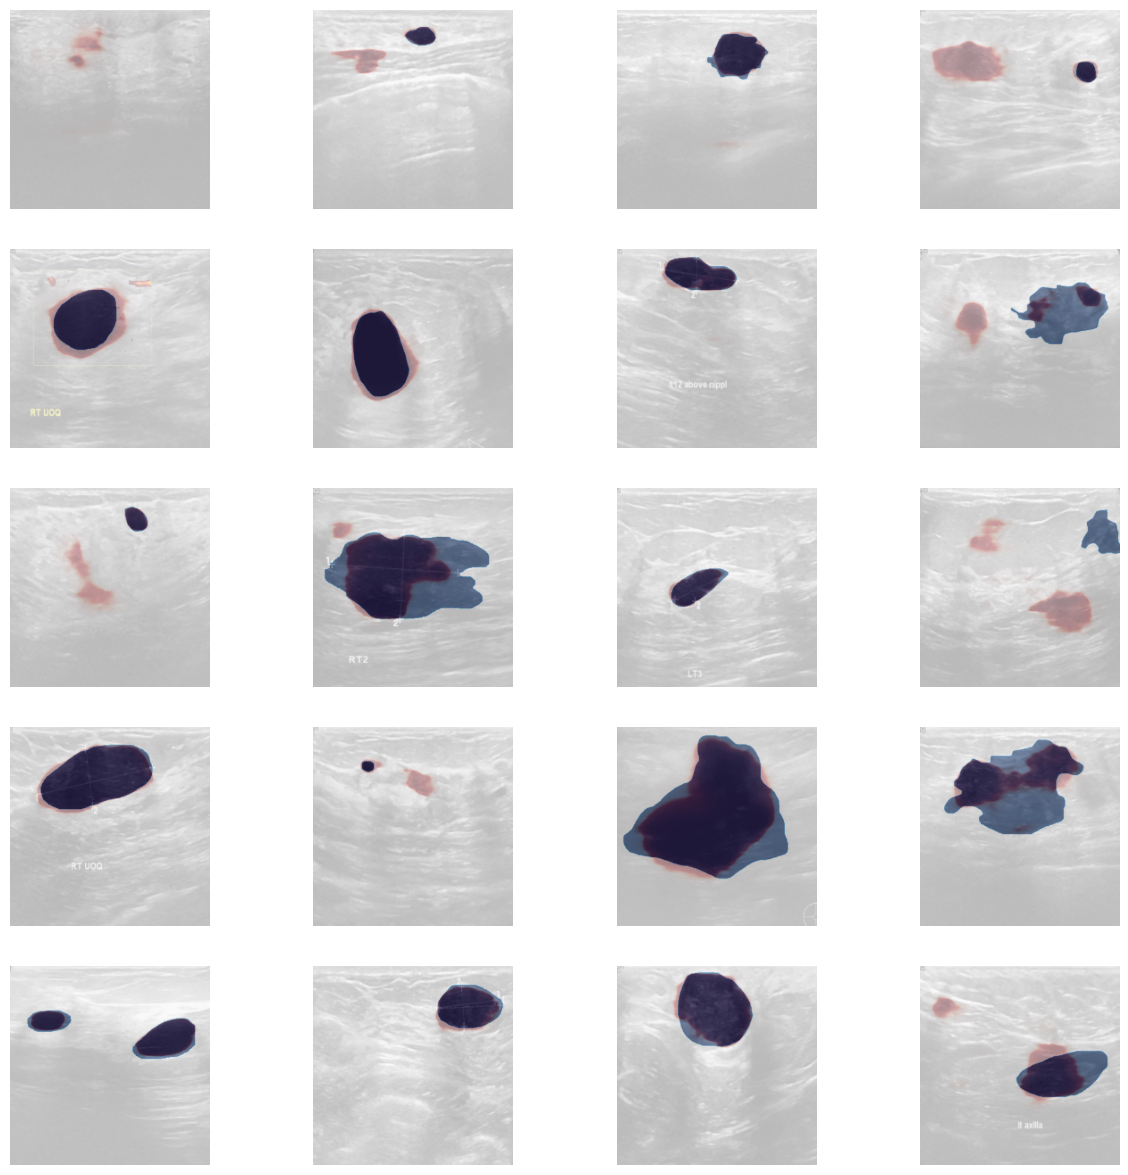

In [93]:
import math
import matplotlib.pyplot as plt
import torch

def test_model(model, loader, num_images=5):
    model.eval()
    images_so_far = 0
    cols = 4  # 每行显示的图片数量
    rows = math.ceil(num_images / cols)  # 动态计算行数
    fig = plt.figure(figsize=(15, 15))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)

            for j in range(inputs.size(0)):
                images_so_far += 1
                if images_so_far > num_images:
                    model.train(mode=True)
                    return

                # 动态分配子图
                ax = plt.subplot(rows, cols, images_so_far)
                ax.axis('off')
                plt.imshow(inputs[j].cpu().numpy().transpose((1, 2, 0)).squeeze(), cmap='gray')
                plt.imshow(outputs[j].cpu().numpy().squeeze(), alpha=0.5, cmap='Reds')
                plt.imshow(labels[j].cpu().numpy().squeeze(), alpha=0.5, cmap='Blues')
    plt.show()


# 使用训练好的模型和测试数据输出几张分类结果
test_model(model, test_loader, num_images=20)

## 模型评价
这个模型整体来看恰当划分出肿瘤和非肿瘤的成分，在细节上也有较好的表现。但是其和ground truth在部分图上的差异也较大，似乎真实反映了肿瘤的精细结构，并找到了没有被正确标注的肿瘤。